In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as kl

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import imgaug as ia
from imgaug import augmenters as iaa

import csv
import glob
import os
import math
import re

# Setup

In [3]:
USE_GDRIVE      = True
PERSISTANT_PATH = '/content/drive/My Drive/retina/'
CHECKPOINT_PATH = PERSISTANT_PATH+'/checkpoints/'
PRETRAINED_PATH = PERSISTANT_PATH+'/pretrained_weights/'
DATA_SRC_PATH   = PERSISTANT_PATH+'/data/'

TEMP_PATH       = '/content/'
DATA_PATH       = TEMP_PATH+'/data/'

if USE_GDRIVE:
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q -n -d '{DATA_PATH}' '{PERSISTANT_PATH+"/data/train_dst.zip"}'
!unzip -q -n -d '{DATA_PATH}' '{PERSISTANT_PATH+"/data/test_dst.zip"}'

In [5]:
!dir '{DATA_PATH}/train_dst' | head
!dir '{DATA_PATH}/test_dst' | head

10003_left.jpeg   19968_left.jpeg   30000_left.jpeg   39972_right.jpeg
10003_right.jpeg  19968_right.jpeg  30000_right.jpeg  39975_left.jpeg
10007_left.jpeg   19970_left.jpeg   30004_left.jpeg   39975_right.jpeg
10007_right.jpeg  19970_right.jpeg  30004_right.jpeg  39978_left.jpeg
10009_left.jpeg   19972_left.jpeg   3000_left.jpeg    39978_right.jpeg
10009_right.jpeg  19972_right.jpeg  3000_right.jpeg   39981_left.jpeg
1000_left.jpeg	  19975_left.jpeg   30012_left.jpeg   39981_right.jpeg
1000_right.jpeg   19975_right.jpeg  30012_right.jpeg  39982_left.jpeg
10010_left.jpeg   19976_left.jpeg   30015_left.jpeg   39982_right.jpeg
10010_right.jpeg  19976_right.jpeg  30015_right.jpeg  39983_left.jpeg
10000_left.jpeg   19996_right.jpeg  29928_right.jpeg  39921_right.jpeg
10000_right.jpeg  19997_left.jpeg   29930_left.jpeg   39922_left.jpeg
10001_left.jpeg   19997_right.jpeg  29930_right.jpeg  39922_right.jpeg
10001_right.jpeg  19998_left.jpeg   29931_left.jpeg   39923_left.jpeg
10002_right.jp

## TFA Kappa Fix
Here we use the already implemented Cohens Kappa from TF Addons. So download it from https://github.com/tensorflow/addons/tree/master/tensorflow_addons.

In [6]:
!curl https://raw.githubusercontent.com/tensorflow/addons/5f9f36c03a5b132da4fe447dfa9df472ab7ea0df/tensorflow_addons/metrics/cohens_kappa.py -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7223  100  7223    0     0  30348      0 --:--:-- --:--:-- --:--:-- 30348


Fix the faulty shape comparision (the original comparison fails on half open tensors).

In [7]:
%%writefile cohens_kappa_fix.patch
--- cohens_kappa.py	2019-12-30 19:47:55.000745582 +0100
+++ cohens_kappa_fix.py	2019-12-30 19:50:25.117155527 +0100
@@ -115,9 +115,10 @@
         y_true = tf.cast(y_true, dtype=tf.int64)
         y_pred = tf.cast(y_pred, dtype=tf.int64)
 
-        if y_true.shape != y_pred.shape:
-            raise ValueError(
-                "Number of samples in `y_true` and `y_pred` are different")
+        tf.debugging.assert_equal(
+            tf.shape(y_true),
+            tf.shape(y_pred),
+            message="Number of samples in `y_true` and `y_pred` are different")
 
         # compute the new values of the confusion matrix
         new_conf_mtx = tf.math.confusion_matrix(

Writing cohens_kappa_fix.patch


In [8]:
!echo "" >> cohens_kappa_fix.patch
!patch cohens_kappa.py < cohens_kappa_fix.patch

patching file cohens_kappa.py


Run cohens_kappa.py in the context within this notebook. Therefore the CohenKappa class becomes accessible.

*Hint: This may have some side effects duo the imports.*

In [0]:
%run -i cohens_kappa.py

# EfficientNet



The EfficientNet-B0 baseline network model is defined as the following:


stage | repeat | kernel size | stride | expansion | input channels | output channels | se ratio
:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
2 | 1 | 3 | 1x1 | 1 | 32 | 16 | 0.25
3 | 2 | 3 | 2x2 | 6 | 16 | 24 | 0.25
4 | 2 | 5 | 2x2 | 6 | 24 | 40 | 0.25
5 | 3 | 3 | 2x2 | 6 | 40 | 80 | 0.25
6 | 3 | 5 | 1x1 | 6 | 80 | 112 | 0.25
7 | 4 | 5 | 2x2 | 6 | 112 | 192 | 0.25
8 | 1 | 3 | 1x1 | 6 | 192 | 320 | 0.25

*Source: https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/efficientnet_builder.py*

The following implementation is based on the EfficientNet [paper](https://arxiv.org/abs/1905.11946) and the original source: https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/.

In [0]:
def activation_fn(x):
  return tf.multiply(tf.math.sigmoid(x), x) # swish: sigmoid(x)*x

keras.utils.get_custom_objects().update({'effnet_activation': activation_fn})

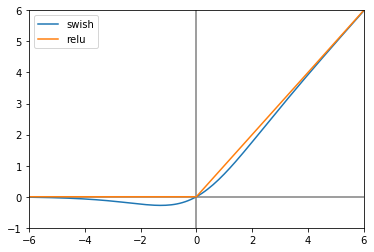

In [11]:
#@title Swish activation function { vertical-output: true, display-mode: "both" }
#@markdown Instead of ReLU, Swish activation function is used in EfficienNet.

x = np.arange(-10.0, 10.0, 0.1)
swish_y = tf.multiply(tf.math.sigmoid(x), x)
relu_y = keras.backend.relu(x)

fig, ax = plt.subplots()
ax.set_adjustable('datalim')
ax.set_xlim(-6, 6)
ax.set_ylim(-1, 6)
ax.axhline(y=0, color='grey')
ax.axvline(x=0, color='grey')
ax.plot(x, swish_y, label='swish')
ax.plot(x, relu_y, label='relu')
ax.legend()
fig.show()

## MBConv block

In [0]:
class MBConv():
  def __init__(self, kernel_size=3, stride=1, expansion=1, input_channels=1, output_channels=1, dropout_rate=0.2, se_ratio=0.25, name=''):
    '''Convolution layer following MobileNetV2 implementation: https://arxiv.org/abs/1801.04381
    
    See Table 1 https://arxiv.org/abs/1801.04381
    and https://arxiv.org/abs/1905.11946
    '''
    assert type(kernel_size) is int and kernel_size >= 1
    assert type(stride) is int and stride >= 1
    assert type(expansion) is int
    assert type(input_channels) is int
    assert type(output_channels) is int
    assert dropout_rate > 0.0 and dropout_rate < 1.0
    assert se_ratio >= 0.0 and se_ratio <= 1.0

    self.kernel_size = (kernel_size, kernel_size)
    self.stride = (stride, stride)
    self.expansion = expansion
    self.input_channels = input_channels
    self.output_channels = output_channels
    self.dropout_rate = dropout_rate
    self.se_ratio = se_ratio

    self.prefix = name + "_"

    self.expansion_channels = self.input_channels * self.expansion

  def __call__(self, input):
    x = input

    # see MobileNetV2 Table 1 and Figure 4d

    # expansion
    if self.expansion != 1:
      # 1x1 conv2d
      x = kl.Conv2D(kernel_size=(1, 1),
                    filters=self.expansion_channels,
                    padding='same',
                    use_bias=False,
                    name=self.prefix + 'expand_conv')(x)
      x = kl.BatchNormalization(name=self.prefix + 'expand_bn')(x)
      x = kl.Activation('effnet_activation')(x) #kl.ReLU(max_value=6) # ReLu6 activation in MobileNetV2
    # else no expansion

    # depthwise convolution
    x = kl.DepthwiseConv2D(kernel_size=self.kernel_size,
                                             strides=self.stride,
                                             padding='same',
                                             use_bias=False,
                                             name=self.prefix + 'dwconv')(x)
    x = kl.BatchNormalization(name=self.prefix + 'bn')(x)
    x = kl.Activation('effnet_activation')(x) #kl.ReLU(max_value=6)

    # squeeze & excitation phase; give each channel an importance weight
    if self.se_ratio != 0.0:
      num_reduced_channels = max(1, int(self.input_channels * self.se_ratio))
      se = kl.GlobalAveragePooling2D()(x) # output shape is (*, channels)
      se = kl.Reshape((1, 1, self.expansion_channels))(se) # reshape to (*, 1, 1, channels)
      se = kl.Conv2D(kernel_size=(1, 1),
                     filters=num_reduced_channels,
                     activation='effnet_activation',
                     use_bias=True,
                     padding='same',
                     name=self.prefix + 'se_reduce')(se)
      se = kl.Conv2D(kernel_size=(1, 1),
                     filters=self.expansion_channels,
                     activation='sigmoid',
                     use_bias=True,
                     padding='same',
                     name=self.prefix + 'se_expand')(se)

      x = kl.multiply([x, se])

    # projection
    x = kl.Conv2D(kernel_size=(1, 1),
                  filters=self.output_channels,
                  padding='same',
                  use_bias=False,
                  name=self.prefix + 'project_conv')(x)
    x = kl.BatchNormalization(name=self.prefix + 'project_bn')(x)
    # linear activation; nothing to do

    # shortcut
    if self.stride == (1, 1) and self.input_channels == self.output_channels:
      x = kl.Dropout(self.dropout_rate)(x)
      x = kl.add([x, input])

    return x

> https://machinethink.net/blog/mobilenet-v2/ for further explanation on the expansion/ projection part

In [0]:
class EfficientNet():
  @staticmethod
  def round_channels(channels, width=1.0, divisor=8):
    assert type(channels) is int and channels >= 1
    assert width >= 1.0
    assert type(divisor) is int and divisor >= 1

    chs = max(divisor, int(channels * width + divisor / 2) // divisor * divisor)

    if chs < 0.9 * (channels * width):
        chs += divisor

    return chs

  @staticmethod
  def round_repeats(repeats, depth=1.0):
    assert type(repeats) is int and repeats >= 1
    assert depth >= 1.0

    return max(1, int(math.ceil(repeats * depth)))

  def __init__(self, num_classes=1, width_coefficient=1.0, depth_coefficient=1.0, dropout_rate=0.2, include_head=True):

    self.num_classes = num_classes
    self.width_coefficient = width_coefficient
    self.depth_coefficient = depth_coefficient
    self.dropout_rate = dropout_rate
    self.include_head = include_head
    
  def __call__(self, input):
    x = input

    # just for readability
    w = self.width_coefficient

    # root
    x = kl.Conv2D(kernel_size=(3, 3),
              filters=self.round_channels(32, width=w),
              strides=(2, 2),
              padding='same',
              use_bias=False,
              name='S1_root_conv')(x)
    x = kl.BatchNormalization(name='S1_root_bn')(x)
    x = kl.Activation('effnet_activation')(x)

    # MBConv blocks config
    # Source: https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/efficientnet_builder.py
    mbconv_config = [
      {'stage': 2, 'repeat': 1, 'kernel size': 3, 'stride': 1, 'expansion': 1, 'input channels': 32, 'output channels': 16, 'se ratio': 0.25},
      {'stage': 3, 'repeat': 2, 'kernel size': 3, 'stride': 2, 'expansion': 6, 'input channels': 16, 'output channels': 24, 'se ratio': 0.25},
      {'stage': 4, 'repeat': 2, 'kernel size': 5, 'stride': 2, 'expansion': 6, 'input channels': 24, 'output channels': 40, 'se ratio': 0.25},
      {'stage': 5, 'repeat': 3, 'kernel size': 3, 'stride': 2, 'expansion': 6, 'input channels': 40, 'output channels': 80, 'se ratio': 0.25},
      {'stage': 6, 'repeat': 3, 'kernel size': 5, 'stride': 1, 'expansion': 6, 'input channels': 80, 'output channels': 112, 'se ratio': 0.25},
      {'stage': 7, 'repeat': 4, 'kernel size': 5, 'stride': 2, 'expansion': 6, 'input channels': 112, 'output channels': 192, 'se ratio': 0.25},
      {'stage': 8, 'repeat': 1, 'kernel size': 3, 'stride': 1, 'expansion': 6, 'input channels': 192, 'output channels': 320, 'se ratio': 0.25}
    ]

    for c in mbconv_config:
      c['repeat'] = self.round_repeats(c['repeat'], self.depth_coefficient)

    # MBConv blocks
    for block in mbconv_config:
      for i in range(block['repeat']):
        x = MBConv(input_channels=self.round_channels(block['input channels'], width=w) if i == 0 else self.round_channels(block['output channels'], width=w),
                   output_channels=self.round_channels(block['output channels'], width=w),
                   kernel_size=block['kernel size'],
                   expansion=block['expansion'],
                   stride=block['stride'] if i == 0 else 1,
                   name=f"S{block['stage']}_MBConv_L{i}")(x)

    # head
    x = kl.Conv2D(kernel_size=(1, 1),
                  filters=self.round_channels(1280, width=w),
                  padding='same',
                  use_bias=False,
                  name='S9_head_conv')(x)
    x = kl.BatchNormalization(name='S9_head_bn')(x)
    x = kl.Activation('effnet_activation')(x) #kl.ReLU(name='S9_ReLU')
    x = kl.GlobalAveragePooling2D()(x)
    if self.include_head:
      x = kl.Dropout(self.dropout_rate)(x)
      x = kl.Dense(self.num_classes, name='S9_head_fc')(x)
      x = kl.Softmax()(x)

    return keras.Model(input, x)


In [0]:
# Source: https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/efficientnet_builder.py
efficientnet_config = {
    # (width_coefficient, depth_coefficient, resolution, dropout_rate)
    'efficientnet-b0': (1.0, 1.0, 224, 0.2),
    'efficientnet-b1': (1.0, 1.1, 240, 0.2),
    'efficientnet-b2': (1.1, 1.2, 260, 0.3),
    'efficientnet-b3': (1.2, 1.4, 300, 0.3),
    'efficientnet-b4': (1.4, 1.8, 380, 0.4),
    'efficientnet-b5': (1.6, 2.2, 456, 0.4),
    #'efficientnet-b6': (1.8, 2.6, 528, 0.5),
    #'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    #'efficientnet-b8': (2.2, 3.6, 672, 0.5),
}

Translate the pretrained weights from the official keras network to ours.

In [0]:
import h5py
import string

'''
Pretrained models from https://github.com/Callidior/keras-applications/releases.
'''
def translate_pretrained():
  def extract_name(l):
    r = re.search("^S(\d+)_MBConv_L(\d+)_(\w+)$", l.name)
    if r != None:
      stage, layer, inner = int(r.group(1)) - 1, string.ascii_lowercase[int(r.group(2))], r.group(3)

      return f'block{stage}{layer}_{inner}' # e.g. 'block1a_project_conv' is the same as 'S2_MBConv_L0_project_conv'
    else:
      return None

  def inject_weights(from_hdf5, to_model):
    with h5py.File(from_hdf5, 'r') as f:
      for l in to_model.layers:
        if isinstance(l, (kl.Conv2D, kl.DepthwiseConv2D, kl.BatchNormalization)):
          matching_name = None

          if l.name == 'S1_root_conv':
            matching_name = 'stem_conv'
          elif l.name == 'S1_root_bn':
            matching_name = 'stem_bn'
          elif l.name == 'S9_head_conv':
            matching_name = 'top_conv'
          elif l.name == 'S9_head_bn':
            matching_name = 'top_bn'
          else:
            matching_name = extract_name(l)

          if matching_name == None or matching_name not in f:
            print(f'ignoring: {l.name}')
            continue
          
          print(f'{matching_name} -> {l.name}')
          weight_paths = f[matching_name].attrs['weight_names']
          weights = [np.array(f[matching_name][w]) for w in weight_paths]

          l.set_weights(weights)

  for name, cfg in efficientnet_config.items():
    keras.backend.clear_session()

    print(f'Processing: {name}_weights_tf_dim_ordering_tf_kernels.h5')
    model = EfficientNet(num_classes=2,
                         width_coefficient=cfg[0],
                         depth_coefficient=cfg[1],
                         dropout_rate=cfg[3],
                         include_head=False)(keras.Input(shape=(cfg[2], cfg[2], 3)))

    inject_weights(f'/content/drive/My Drive/retina/pretrained_weights/{name}_weights_tf_dim_ordering_tf_kernels.h5', model)
    model.save_weights(f'/content/drive/My Drive/retina/pretrained_weights/{name}_pretrained.hdf5', overwrite=True)

#translate_pretrained()

# Data preparation

1. Read labeled CSV file(s) (original test & train files)
2. Merge train and test data
3. Shuffle the data
3. Split data to train and validation
4. Downsample the first class within the train data to balance the dataset
6. Shuffle again



In [0]:
train = pd.read_csv(f'{DATA_SRC_PATH}/train_labels.csv')
test = pd.read_csv(f'{DATA_SRC_PATH}/test_labels.csv')

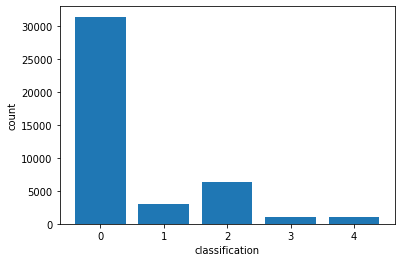

In [17]:
#@title Private data distribution used to evaluate the submissions: { vertical-output: true }

clazz, count = np.unique(test[test['Usage'] == 'Private']['level'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(clazz, count)
ax.set_xlabel('classification')
ax.set_ylabel('count')
fig.show()

In [0]:
test = test.drop(['Usage'], axis=1)

train['image'] = train['image'].apply(lambda f: f'train_dst/{f}.jpeg')
test['image'] = test['image'].apply(lambda f: f'test_dst/{f}.jpeg')

data = pd.concat([train, test]).sample(frac=1, random_state=97309938) # concat & shuffle data

def drop(s):
  if os.path.exists('/content/data/'+s):
    return s
  else:
    return np.nan
data['image'] = data['image'].apply(drop)
data = data.dropna()

In [19]:
data

image  level
18337  train_dst/23095_right.jpeg      3
13617   test_dst/11328_right.jpeg      2
15616    test_dst/12957_left.jpeg      0
32626    test_dst/27055_left.jpeg      0
9066    train_dst/11378_left.jpeg      0
...                           ...    ...
42352    test_dst/35006_left.jpeg      0
31559   test_dst/26161_right.jpeg      0
35946    test_dst/29747_left.jpeg      0
10115  train_dst/12739_right.jpeg      2
30189  train_dst/38189_right.jpeg      1

[88534 rows x 2 columns]

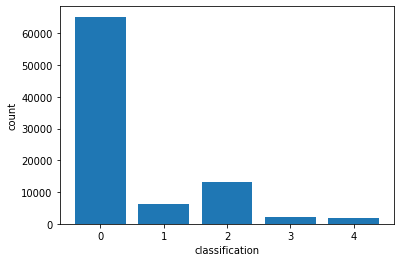

In [20]:
#@title Original distribution: { vertical-output: true }

clazz, count = np.unique(data['level'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(clazz, count)
ax.set_xlabel('classification')
ax.set_ylabel('count')
fig.show()

In [21]:
split = int(len(data)*0.15)
test_df = data.iloc[:split].copy().reset_index(drop=True)
train_df = data.iloc[split:].copy()

train_c0 = train_df[train_df['level'] == 0]
train_c0 = train_c0.iloc[:len(train_c0)//4]
train_cP = train_df[train_df['level'] > 0]

train_df = pd.concat([train_c0, train_cP]).sample(frac=1, random_state=69859680).reset_index(drop=True) # concat & shuffle data
#train_df = train_df.iloc[:(len(train_df)//128)*128]

train_df

image  level
0         test_dst/1778_left.jpeg      0
1         test_dst/6664_left.jpeg      2
2       test_dst/12142_right.jpeg      0
3       train_dst/33202_left.jpeg      2
4       test_dst/30221_right.jpeg      2
...                           ...    ...
33624  train_dst/43539_right.jpeg      2
33625     test_dst/7799_left.jpeg      0
33626   train_dst/23428_left.jpeg      0
33627   train_dst/1471_right.jpeg      3
33628   test_dst/11372_right.jpeg      0

[33629 rows x 2 columns]

Oversampling all minor classes results in a poorer performance of the network; the validation loss settles way faster on a higher magnitude.

In [0]:
# train_c = [train_df[train_df['level'] == i] for i in range(5)]
# train_c = [pd.concat([t]*5).iloc[:8000] for t in train_c]

# train_df = pd.concat(train_c)
# # train_df = pd.concat(
# #     [train_c[0], train_c[2]] +
# #     [train_c[1]]*2 +
# #     [train_c[3], train_c[4]]*6
# # ).sample(frac=1)
# # train_df['weight'] = train_df['level'].map({0: 0.5, 1: 1.0, 2: 0.5, 3: 1.0, 4: 1.0})
# train_df

In [0]:
assert pd.merge(left=train_df, right=test_df, left_on='image', right_on='image').shape[0] == 0

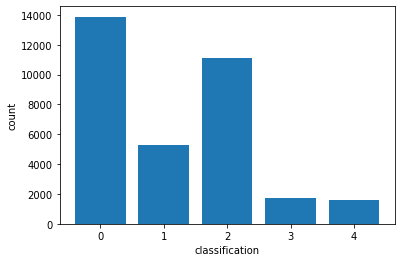

In [24]:
#@title Train data: { vertical-output: true }

clazz, count = np.unique(train_df['level'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(clazz, count)
ax.set_xlabel('classification')
ax.set_ylabel('count')
fig.show()

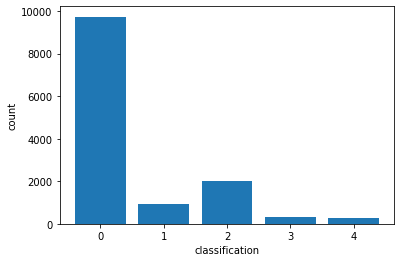

In [25]:
#@title Test data: { vertical-output: true }

clazz, count = np.unique(test_df['level'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(clazz, count)
ax.set_xlabel('classification')
ax.set_ylabel('count')
fig.show()

# Train

In [0]:
#@title Define model { vertical-output: true, display-mode: "both" }

#keras.backend.clear_session()

MODEL = "efficientnet-b3" #@param ["efficientnet-b0", "efficientnet-b1", "efficientnet-b2", "efficientnet-b3", "efficientnet-b4", "efficientnet-b5"]
BATCH_SIZE = 48 #@param {type:"slider", min:16, max:128, step:4}
MEM_BATCHES = 16

IMG_SIZE = 224 #@param [224, 240, 260, 300, 320, 380, 384, 456, 512] {type:"raw"}

CFG = efficientnet_config[MODEL]

def create_model(img_size=IMG_SIZE):
  input = keras.Input(shape=(img_size, img_size, 3))
  base = EfficientNet(num_classes=5, include_head=False,
                      width_coefficient=CFG[0],
                      depth_coefficient=CFG[1],
                      dropout_rate=CFG[3])(input)

  x = base.output
  x = kl.Dropout(0.1)(x)
  x = kl.Dense(1, activation='linear')(x)

  return keras.Model(input, x)

In [0]:
aug_seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Flipud(0.5),
  iaa.Affine(rotate=(0, 360)),
  # zoom into random region
  # iaa.Sometimes(0.33, [
  #   iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)}),
  #   iaa.Crop(percent=(0.01, 0.15), sample_independently=False), # crop image equally on both sides
  # ]),
  iaa.Multiply((0.8, 1.2), per_channel=True),
])

datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda img: np.clip(aug_seq.augment_image(img) / 255.0, 0, 1))

def datagen_flow(train_df, test_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
  train_generator = datagen.flow_from_dataframe(
      dataframe=train_df,
      x_col='image',
      y_col='level',
      class_mode='raw',
      batch_size=batch_size,
      target_size=(img_size, img_size),
      directory=DATA_PATH,
      interpolation='bilinear',
      validate_filenames=True)

  validation_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(
      dataframe=test_df,
      x_col='image',
      y_col='level',
      class_mode='raw',
      batch_size=batch_size * 2,
      target_size=(img_size, img_size),
      directory=DATA_PATH,
      interpolation='bilinear',
      validate_filenames=True)
  
  return (train_generator, validation_generator)

Found 33629 validated image filenames.
Found 13280 validated image filenames.


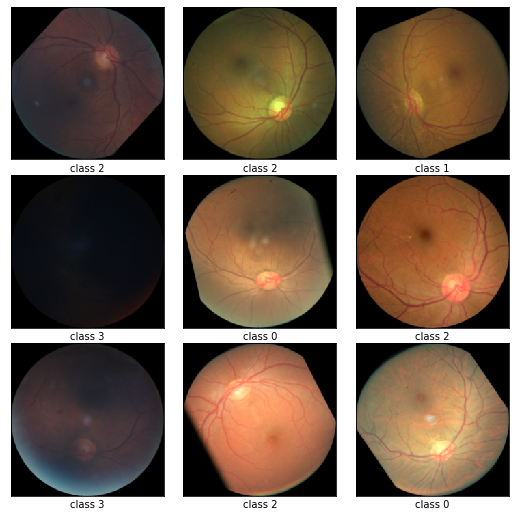

In [28]:
#@title Samples from augmented dataset: { vertical-output: true }

def plot_images(batch):
  images, labels = batch[0], batch[1]

  fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
  fig.subplots_adjust(wspace=0.1, hspace=0.1)
  for i, a in enumerate(axs.flat):
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(images[i])
    # a.set_xlabel(f'class {5 - np.argmax(labels[i] == 0) -1}')
    a.set_xlabel(f'class {labels[i]}')

  fig.show()

g, _ = datagen_flow(train_df, test_df)
plot_images(g[0])

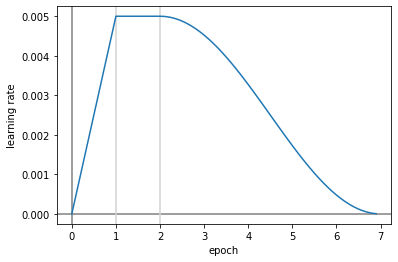

In [29]:
#@title Example cosine decay learning rate scheduler with linear startup { run: "auto", vertical-output: true }
#@markdown Not used anymore.

class CosineDecayLRScheduler(keras.callbacks.Callback):
  def __init__(self, initial_lr, epochs, steps_per_epoch,
               startup_until_epoch=0,
               hold_for=0,
               update_every_n_batches=1):
    super(CosineDecayLRScheduler, self).__init__()

    assert startup_until_epoch + hold_for < epochs

    self.initial_lr = initial_lr
    self.decay = keras.experimental.CosineDecay(initial_lr, epochs - startup_until_epoch - hold_for)
    self.steps_per_epoch = 1/steps_per_epoch
    self.startup_until_epoch = startup_until_epoch
    self.hold_for = hold_for

    self.history = {}

  def next_lr(self, step):
    if step < self.startup_until_epoch:
      return self.initial_lr * (step / self.startup_until_epoch)
    elif step < self.startup_until_epoch + self.hold_for:
      return self.initial_lr
    else:
      return self.decay(step - self.startup_until_epoch - self.hold_for)

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch = epoch
    
  def on_batch_begin(self, batch, logs={}):
    lr = self.next_lr(self.epoch + self.steps_per_epoch * batch)

    keras.backend.set_value(self.model.optimizer.lr, lr)

  def on_batch_end(self, batch, logs={}):
    lr = keras.backend.get_value(self.model.optimizer.lr)
    self.history.setdefault('lr', []).append(lr)

COS_STARTUP = 1 #@param {type:"slider", min:0, max:10, step:1}
COS_HOLD_FOR = 1 #@param {type:"slider", min:0, max:10, step:1}
COS_EPOCHS = 7 #@param {type:"slider", min:1, max:20, step:1}
COS_STEPS_PER_EPOCH = 10 #@param {type:"slider", min:1, max:10, step:1}

def plot_decay():
  cos_decay = CosineDecayLRScheduler(0.005,
                                     COS_EPOCHS,
                                     COS_STEPS_PER_EPOCH,
                                     startup_until_epoch=COS_STARTUP,
                                     hold_for=COS_HOLD_FOR)
  cos_decay_x = np.arange(0, COS_EPOCHS, 1/COS_STEPS_PER_EPOCH)
  cos_decay_y = [cos_decay.next_lr(i) for i in cos_decay_x]

  fig, ax = plt.subplots()
  ax.set_adjustable('datalim')
  ax.axhline(y=0, color='grey')
  ax.axvline(x=0, color='grey')
  ax.axvline(x=COS_STARTUP, color='lightgrey')
  ax.axvline(x=COS_STARTUP+COS_HOLD_FOR, color='lightgrey')
  ax.plot(cos_decay_x, cos_decay_y)
  ax.set_xlabel('epoch')
  ax.set_ylabel('learning rate')
  fig.show()

plot_decay()

Train the network with a decaying learning rate and handle the retinal classification as a regression problem.

This is inspired by Dimitre Oliveiras [Notebook](https://github.com/dimitreOliveira/APTOS2019BlindnessDetection) for the similar challenge [APTOS 2019](https://www.kaggle.com/c/aptos2019-blindness-detection).


In [0]:
class HistoryLogger(keras.callbacks.Callback):
  def __init__(self, prefix):
    super(HistoryLogger, self).__init__()

    self.prefix = prefix
    self.history = {}

  def on_epoch_begin(self, epoch, logs={}):
    self.history = {}

  def on_epoch_end(self, epoch, logs={}):
    df = pd.DataFrame.from_dict(self.history)
    df.to_hdf(f'{PERSISTANT_PATH}/history/{self.prefix}.hdf5', key=f'E{epoch}', mode='a')

    hist = {}
    for k, v in logs.items():
      hist.setdefault(k, []).append(v)

    df = pd.DataFrame.from_dict(hist)
    df.to_hdf(f'{PERSISTANT_PATH}/history/{self.prefix}.hdf5', key=f'VAL_E{epoch}', mode='a')

  def on_batch_end(self, batch, logs={}):
    for k, v in logs.items():
      self.history.setdefault(k, []).append(v)

class KappaMetric(CohenKappa):
  def __init__(self):
    super().__init__(num_classes=5, weightage='quadratic')

  @staticmethod
  def classify(x):
    return tf.case(
        [(tf.less(x, 0.5), lambda: 0.0),
          (tf.less(x, 1.5), lambda: 1.0),
          (tf.less(x, 2.5), lambda: 2.0),
          (tf.less(x, 3.5), lambda: 3.0)],
        default=lambda: 4.0, exclusive=False)

  def update_state(self, y_true, y_pred, sample_weight=None):
    t = tf.reshape(y_true, shape=[-1])
    p = tf.map_fn(KappaMetric.classify, y_pred)
    return super().update_state(t, p, sample_weight)

class AccuracyMetric(tf.keras.metrics.Accuracy):
  def __init__(self):
    super().__init__()

  def update_state(self, y_true, y_pred, sample_weight=None):
    t = tf.reshape(y_true, shape=[-1])
    p = tf.map_fn(KappaMetric.classify, y_pred)
    return super().update_state(t, p, sample_weight)

In [0]:
#@title Train the last dense layer: { vertical-output: true }
#@markdown All layers are frozen for training, except the last dense layer.

HEAD_EPOCHS = 3 #@param {type:"integer"}
HEAD_INTITAL_LEARNING_RATE = 0.001 #@param {type:"number"}

def train_dense(model):
  model.load_weights(f'{PRETRAINED_PATH}/{MODEL}_pretrained.hdf5', by_name=True)
  
  cp_callback = keras.callbacks.ModelCheckpoint(filepath=f'{CHECKPOINT_PATH}/{MODEL}'+'_weights_head_{epoch:002d}_{val_loss:.2f}.hdf5',
                                                save_weights_only=True)
  hs_callback = HistoryLogger(f'{MODEL}_history_head')

  # Train last dense layer

  for l in model.layers:
    l.trainable = False

  model.layers[-2].trainable = True
  model.layers[-1].trainable = True

  #

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=HEAD_INTITAL_LEARNING_RATE),
                loss='mse',
                metrics=['mae', KappaMetric()])
  model.summary()

  train_generator, validation_generator = datagen_flow(train_df, test_df)

  model.fit(train_generator,
            callbacks=[cp_callback, hs_callback],
            epochs=HEAD_EPOCHS,
            validation_data=validation_generator,
            max_queue_size=MEM_BATCHES,
            workers=4, use_multiprocessing=True)

train_dense(create_model())

In [0]:
#@title Train the full network: { vertical-output: true }
#@markdown All layers are trainable. Fine tune the network with a low learning rate.

FULL_EPOCHS = 40 #@param {type:"integer"}
# FULL_WARMUP_EPOCHS = 5 #@param {type:"integer"}
# FULL_HOLD_FOR =  3#@param {type:"integer"}
FULL_INTITAL_LEARNING_RATE = 5e-4 #@param {type:"number"}
FULL_LOAD_MODE = "continue" #@param ["head", "continue", "start"]

def train_full(model):
  last_epoch = 0
  fname      = ''
  if FULL_LOAD_MODE == 'head':
    fname = sorted(glob.glob(f'{CHECKPOINT_PATH}/{MODEL}_weights_head_*.hdf5'))[-1]
    model.load_weights(fname)
  elif FULL_LOAD_MODE == 'continue':
    fname = sorted(glob.glob(f'{CHECKPOINT_PATH}/{MODEL}_weights_full_*.hdf5'))[-1]
    last_epoch = int(re.search("^.*weights_(full|head)_(\d+)_.*$", fname).group(2))

    model.load_weights(fname)
  elif FULL_LOAD_MODE == 'start':
    fname = f'{PRETRAINED_PATH}/{MODEL}_pretrained.hdf5'
    model.load_weights(fname, by_name=True)

  print(f'loaded weights from: {fname}')

  cp_callback = keras.callbacks.ModelCheckpoint(
      filepath=f'{CHECKPOINT_PATH}/{MODEL}'+'_weights_full_{epoch:002d}_{loss:.5f}_{val_loss:.5f}.hdf5',
      save_weights_only=True)
  
  hs_callback = HistoryLogger(f'{MODEL}_history_full')

  model.compile(optimizer=keras.optimizers.Adam(lr=FULL_INTITAL_LEARNING_RATE),
                loss='mse',
                metrics=['mae', KappaMetric()])
  model.summary()

  train_generator, validation_generator = datagen_flow(train_df,
                                                       test_df.iloc[:len(test_df)],
                                                       batch_size=BATCH_SIZE,
                                                       img_size=IMG_SIZE)

  # # with warmup phase
  # lr_callback = CosineDecayLRScheduler(FULL_INTITAL_LEARNING_RATE,
  #                                      FULL_EPOCHS,
  #                                      len(train_generator),
  #                                      startup_until_epoch=FULL_WARMUP_EPOCHS,
  #                                      hold_for=FULL_HOLD_FOR)
  
  print()
  print(f'BATCH_SIZE: {BATCH_SIZE}')
  print(f'IMG_SIZE: {IMG_SIZE}')
  print()

  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.3,
                                                patience=3, min_lr=1e-6,
                                                min_delta=1e-2,
                                                mode='min',
                                                verbose=1)
  
  model.fit(train_generator,
            callbacks=[cp_callback, hs_callback, reduce_lr],
            epochs=FULL_EPOCHS,
            initial_epoch=last_epoch,
            validation_data=validation_generator,
            max_queue_size=MEM_BATCHES,
            workers=4, use_multiprocessing=False)
          
train_full(create_model())

In [0]:
hist = pd.DataFrame({'cohen_kappa' : []})
fig, ax = plt.subplots()
for i in range(14):
  #try:
    key = f'E{i}'
    history_df = pd.read_hdf(f'{PERSISTANT_PATH}/history/efficientnet-b3_history_full.hdf5', key=key)

    #ax.plot(history_df['batch'], history_df['cohen_kappa'], label=key)
    hist = pd.concat([hist, history_df], ignore_index=True)
  #except:
    #None

ax.plot(np.arange(hist.shape[0]), hist['cohen_kappa'], label='cohen_kappa')
ax.legend()
fig.show()

# Predict

In [57]:
keras.backend.clear_session()

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    shuffle=False,
    batch_size=BATCH_SIZE*2,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    interpolation='bilinear',
    validate_filenames=True)

model = create_model(img_size=IMG_SIZE)
fname = sorted(glob.glob(f'{CHECKPOINT_PATH}/{MODEL}_weights_full_*.hdf5'), key=lambda f: f.split('_')[-1])[0]
model.load_weights(fname)

print(f'Loaded checkpoint with lowest loss: {fname}')

progbar = tf.keras.utils.Progbar(len(test_generator))

y_predicted, y_true = [], []
for i in range(len(test_generator)):
  x, y = test_generator[i]
  preds = model.predict(x).flatten()

  del x

  y_true.extend(y)
  y_predicted.extend(preds)
  
  progbar.update(i)

del model

Found 13280 validated image filenames.
Loaded checkpoint with lowest loss: /content/drive/My Drive/retina//checkpoints/efficientnet-b3_weights_full_16_0.37814_0.33852.hdf5
138/139 [============================>.] - ETA: 0s

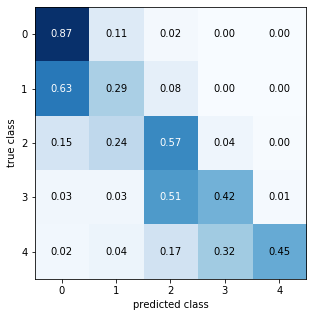

In [83]:
def classify(x):
  if x < 0.5:
      return 0
  elif x < 1.5:
      return 1
  elif x < 2.5:
      return 2
  elif x < 3.5:
      return 3
  return 4

y_predicted_c = [int(classify(y)) for y in y_predicted]
y_true_c = [int(y) for y in y_true]

confusion_matrix = tf.math.confusion_matrix(y_true_c, y_predicted_c,
                                            num_classes=5,
                                            dtype=tf.dtypes.float32).numpy()

confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1).reshape((-1, 1))

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(confusion_matrix, cmap = plt.cm.Blues)#, vmax=1.0, vmin=0.0)
ax.set_xlabel('predicted class')
ax.set_ylabel('true class')

for (i, j), z in np.ndenumerate(confusion_matrix):
  c = 'white' if z > 1/2 else 'black'
  ax.text(j, i, f'{z:0.2f}', ha='center', va='center', color=c)

fig.show()

In [72]:
kpm = KappaMetric()
kpm.update_state(np.array(y_true_c, dtype=np.float32), np.array(y_predicted_c, dtype=np.float32))
kpm.result().numpy()

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[8.461e+03, 1.107e+03, 1.550e+02, 9.000e+00, 1.000e+00],
       [5.860e+02, 2.730e+02, 7.200e+01, 2.000e+00, 0.000e+00],
       [3.060e+02, 4.730e+02, 1.145e+03, 7.500e+01, 8.000e+00],
       [9.000e+00, 9.000e+00, 1.610e+02, 1.330e+02, 4.000e+00],
       [7.000e+00, 1.300e+01, 4.900e+01, 9.200e+01, 1.300e+02]],
      dtype=float32)>

# Acknowledgments
Thanks to [EyePACS](http://www.eyepacs.com/) for providing the retinal images for the [original competition](https://www.kaggle.com/c/diabetic-retinopathy-detection).

Cuadros, J., & Bresnick, G. (2009). EyePACS: an adaptable telemedicine system for diabetic retinopathy screening. _Journal of diabetes science and technology_, _3_(3), 509–516.

# License

BSD 2-Clause License

Copyright (c) 2019, Tobias S.\
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

